<a href="https://colab.research.google.com/github/mtodisco10/fastaiProjects/blob/master/architecture_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Architecture Styles from Building Images with fast.ai

Using fast.ai the below model was trained on images of buildings in 4 categories:
- Classical
- Gothic
- Modern
- Victorian

The result is a predictive model that given an image can classify the images as one of the 4 architecture styles.  The model is limited to these 4 styles so pictures of ranch style houses, medieval castles, or lego blocks won't be relevant.

It's also important to note that this code was based off the course from 2019.  A newer version was recently released in 2020.

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from fastai.vision import *
from fastai.metrics import error_rate

In [7]:
# Downloading pics to their own folders
path = Path('architecture/buildings')
def download_pics(category_lst):
  for f in category_lst:
    print(f'Downloading {f} images')
    folder = f
    file = f + '.csv'
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)
    download_images(file, dest, max_pics=200)

category_lst = ['classical','gothic','modern','victorian']
download_pics(category_lst)

In [8]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

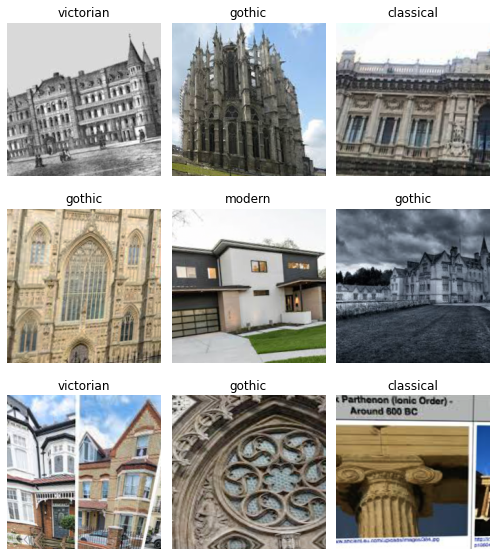

In [9]:
data.show_batch(rows=3, figsize=(7,8))

In [10]:
classes = ['classical', 'gothic', 'modern', 'victorian']
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

classical


gothic


modern


victorian


# Train the Model

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [12]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.198360,1.085653,0.373494,00:05
1,1.462386,0.750370,0.204819,00:04
2,1.101394,0.769113,0.192771,00:04
3,0.902023,0.736131,0.192771,00:04


In [13]:
learn.save('stage-1')

In [14]:
learn.unfreeze()

In [15]:
learn.fit_one_cycle(6, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.489990,0.714729,0.192771,00:05
1,0.378346,0.629433,0.180723,00:04
2,0.307562,0.716328,0.180723,00:04
3,0.267235,0.710369,0.180723,00:05
4,0.237372,0.676430,0.180723,00:05
5,0.213537,0.618574,0.180723,00:04


In [16]:
interp = ClassificationInterpretation.from_learner(learn)

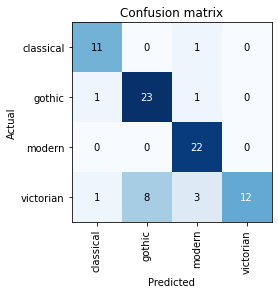

In [17]:
interp.plot_confusion_matrix()

In [18]:
print('This isn\'t too shabby for a first try')
learn.save('stage-2')

This isn't too shabby for a first try


Cleaning the Data

In [19]:
from fastai.widgets import *
db = (ImageList.from_folder(path)
.split_none()
.label_from_folder()
.transform(get_transforms(), size=224)
.databunch())
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-2');

In [20]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

### Deploying the Model

In [21]:
learn.export()

In [22]:
defaults.device = torch.device('cpu')

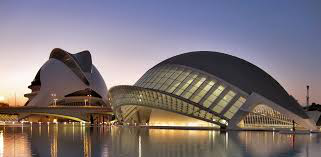

In [55]:
img = open_image(path/'modern'/'00000003.jpg')
img

In [56]:
learn = load_learner(path)

In [57]:
pred_class, pred_idx, outputs = learn.predict(img)

In [58]:
print('Classifying as {} with {}% confidence'.format(pred_class.obj, (outputs[pred_idx] * 100)))

Classifying as modern with 99.18254852294922% confidence


# Deployment
The model was deployed with [Render](https://render.com/).

Visit https://classifying-building-architecture.onrender.com/ and upload a building picture to have the model predict one of the four architecture styles